In [58]:
import os
import cv2

import imagehash
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

from scipy.fftpack import fft2, fftshift

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [16]:
dataset_path = 'data/'

In [3]:
cat_species = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
num_cat_species = len(cat_species)

print(f"Number of types of cats: {num_cat_species}")
print("Cat species:")
print('\n'.join(cat_species))

Number of types of cats: 7
Cat species:
african-wildcat
blackfoot-cat
chinese-mountain-cat
domestic-cat
european-wildcat
jungle-cat
sand-cat


In [4]:
image_counts = {}

for species in cat_species:
    species_path = os.path.join(dataset_path, species)
    num_images = len([f for f in os.listdir(species_path) if os.path.isfile(os.path.join(species_path, f))])
    image_counts[species] = num_images

# Convert to DataFrame for better readability
image_counts_df = pd.DataFrame(list(image_counts.items()), columns=['Species', 'Number of Images'])
image_counts_df

,Species,Number of Images
0,african-wildcat,87
1,blackfoot-cat,78
2,chinese-mountain-cat,37
3,domestic-cat,59
4,european-wildcat,57
5,jungle-cat,80
6,sand-cat,67


In [5]:
# Dictionary to store the number of images for each species
image_counts = {}

for species in cat_species:
    species_path = os.path.join(dataset_path, species)
    image_files = [f for f in os.listdir(species_path) if f.endswith('.jpg')]

    image_counts[species] = len(image_files)

    print("The output format (height, width, channels):")
    
    for image_file in image_files:
        image_path = os.path.join(species_path, image_file)
        
        # Read the image 
        img = cv2.imread(image_path)
        
        if img is not None:
            print(f"{image_file}: {img.shape}")
        else:
            print(f"Error opening image {image_file}")

The output format (height, width, channels):
af (1).jpg: (190, 265, 3)
af (10).jpg: (184, 274, 3)
af (11).jpg: (183, 275, 3)
af (12).jpg: (192, 263, 3)
af (13).jpg: (219, 230, 3)
af (14).jpg: (275, 183, 3)
af (15).jpg: (183, 275, 3)
af (16).jpg: (209, 241, 3)
af (17).jpg: (168, 300, 3)
af (18).jpg: (183, 275, 3)
af (19).jpg: (195, 258, 3)
af (2).jpg: (194, 259, 3)
af (20).jpg: (258, 195, 3)
af (21).jpg: (124, 220, 3)
af (22).jpg: (225, 225, 3)
af (23).jpg: (183, 275, 3)
af (24).jpg: (192, 262, 3)
af (25).jpg: (264, 191, 3)
af (26).jpg: (258, 195, 3)
af (27).jpg: (183, 275, 3)
af (28).jpg: (183, 275, 3)
af (29).jpg: (191, 264, 3)
af (3).jpg: (225, 225, 3)
af (30).jpg: (194, 259, 3)
af (31).jpg: (201, 250, 3)
af (33).jpg: (259, 195, 3)
af (34).jpg: (225, 225, 3)
af (35).jpg: (183, 275, 3)
af (36).jpg: (190, 265, 3)
af (38).jpg: (267, 189, 3)
af (39).jpg: (190, 265, 3)
af (4).jpg: (185, 272, 3)
af (40).jpg: (192, 262, 3)
af (41).jpg: (183, 275, 3)
af (42).jpg: (183, 275, 3)
af (43).jpg: (

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

Let's get the perceptual hash of an image fith this function:

In [6]:
def get_image_hash(image_path):
    try:
        # Open the image using PIL
        with Image.open(image_path) as img:
            # Compute and return the perceptual hash of the image
            return imagehash.phash(img)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

image_hashes = {}
duplicate_images = []

for species in os.listdir(dataset_path):
    species_path = os.path.join(dataset_path, species)
    
    if os.path.isdir(species_path):
        for image_file in os.listdir(species_path):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(species_path, image_file)
                
                # Compute the perceptual hash of the image
                img_hash = get_image_hash(image_path)
                
                if img_hash is not None:
                    if img_hash in image_hashes:
                        duplicate_images.append(image_path)
                    else:
                        image_hashes[img_hash] = image_path

print("\nDuplicate images:")
for img in duplicate_images:
    print(img)


Duplicate images:


In [7]:
for img in duplicate_images:
    os.remove(img)
    print(f"Removed {img}")

print("\nDuplicate image detection completed.")


Duplicate image detection completed.


### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [8]:
# Load the pre-trained ResNet50 model with weights trained on ImageNet
model = tf.keras.applications.ResNet50(weights='imagenet')

# Display the model architecture
model.summary()

# Get the total number of layers
num_layers = len(model.layers)
print(f"Total number of layers: {num_layers}")

# Get the total number of parameters
total_params = model.count_params()
print(f"Total number of parameters: {total_params}")

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

Total number of layers: 177
Total number of parameters: 25636712


### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [9]:
# Set the required image dimensions for the model
image_height = 224
image_width = 224

# Here we will store the processed images
images = []

# Iterate over each category (species) directory in the dataset
for species in os.listdir(dataset_path):
    species_path = os.path.join(dataset_path, species)
    
    # Check if it is a directory
    if os.path.isdir(species_path):
        for image_file in os.listdir(species_path):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(species_path, image_file)
                image = cv2.imread(image_path)
                
                if image is not None:
                    # Resize the image
                    resized_image = cv2.resize(image, (image_height, image_width))

                    # Preprocess the image for ResNet50
                    preprocessed_image = tf.keras.applications.resnet50.preprocess_input(resized_image)
                    
                    # Append the processed image to the list
                    images.append(preprocessed_image)

# Convert the list to a NumPy array
images_np = np.array(images)

# Check if the images are resized successfully
images_np.shape

(465, 224, 224, 3)

In [10]:
# Save the processed images as a .npy file
output_dir = "train_test"
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, 'images_test.npy'), images_np)

# Load the .npy file to verify
loaded_images = np.load(os.path.join(output_dir, 'images_test.npy'))

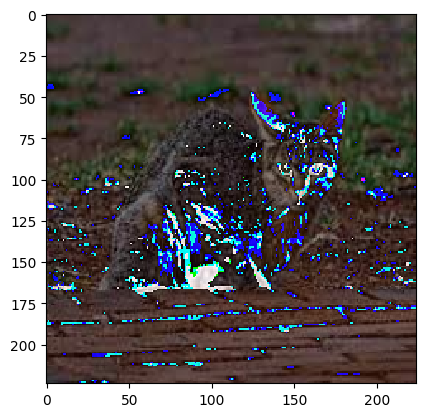

In [11]:
# Plot an example image
plt.imshow(loaded_images[24].astype(np.uint8), interpolation='nearest')
plt.show()

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [22]:
# Set the required image dimensions for the model
image_height = 224
image_width = 224
batch_size = 4  # Number of images to process in each batch

# Function to preprocess and save images in batches
def process_and_save_batches(dataset_path, batch_size, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    batch_count = 0
    images_batch = []

    # Iterate over each category (species) directory in the dataset
    for species in os.listdir(dataset_path):
        species_path = os.path.join(dataset_path, species)
        
        if os.path.isdir(species_path):
            for image_file in os.listdir(species_path):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(species_path, image_file)
                    image = cv2.imread(image_path)
                    
                    if image is not None:
                        # Resize the image
                        resized_image = cv2.resize(image, (image_height, image_width))
                        
                        # Preprocess the image for ResNet50
                        preprocessed_image = tf.keras.applications.resnet50.preprocess_input(resized_image)
                        
                        # Append the processed image to the batch
                        images_batch.append(preprocessed_image)
                        
                        # If batch is full, save it to a .npy file
                        if len(images_batch) >= batch_size:
                            batch_filename = f'batch_{batch_count}.npy'
                            np.save(os.path.join(output_dir, batch_filename), np.array(images_batch))
                            batch_count += 1
                            images_batch = []
    
    # Save remaining images if there are any
    if images_batch:
        batch_filename = f'batch_{batch_count}.npy'
        np.save(os.path.join(output_dir, batch_filename), np.array(images_batch))

# Define the output directory
output_dir = "train_test_batches"
process_and_save_batches(dataset_path, batch_size, output_dir)

Loading Batches Lazily:

In [21]:
# Function to load images from a batch file
def load_images_from_batch(batch_file):
    return np.load(batch_file)

# Load all batches from the output directory
def load_all_batches(output_dir):
    batches = []
    for filename in sorted(os.listdir(output_dir)):
        if filename.endswith('.npy'):
            batch_path = os.path.join(output_dir, filename)
            batch_images = load_images_from_batch(batch_path)
            batches.append(batch_images)
    return np.concatenate(batches, axis=0)  # Combine all batches

# Load all batches
all_images = load_all_batches(output_dir)
print(f'Loaded images: {all_images}')

Loaded images: [[[[ 4.9060997e+01  2.2210007e+00 -4.2680000e+01]
   [ 4.9060997e+01  2.2210007e+00 -4.2680000e+01]
   [ 4.9060997e+01  2.2210007e+00 -4.2680000e+01]
   ...
   [ 2.4060997e+01 -9.7789993e+00 -5.9680000e+01]
   [ 2.4060997e+01 -9.7789993e+00 -5.9680000e+01]
   [ 2.5060997e+01 -8.7789993e+00 -5.8680000e+01]]

  [[ 4.9060997e+01  2.2210007e+00 -4.2680000e+01]
   [ 4.9060997e+01  2.2210007e+00 -4.2680000e+01]
   [ 4.9060997e+01  2.2210007e+00 -4.2680000e+01]
   ...
   [ 2.4060997e+01 -9.7789993e+00 -5.9680000e+01]
   [ 2.4060997e+01 -9.7789993e+00 -5.9680000e+01]
   [ 2.5060997e+01 -8.7789993e+00 -5.8680000e+01]]

  [[ 4.9060997e+01  2.2210007e+00 -4.2680000e+01]
   [ 4.9060997e+01  2.2210007e+00 -4.2680000e+01]
   [ 4.9060997e+01  2.2210007e+00 -4.2680000e+01]
   ...
   [ 2.5060997e+01 -8.7789993e+00 -5.8680000e+01]
   [ 2.4060997e+01 -9.7789993e+00 -5.9680000e+01]
   [ 2.5060997e+01 -8.7789993e+00 -5.8680000e+01]]

  ...

  [[ 2.4060997e+01  1.1221001e+01  4.3199997e+00]
 

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [23]:
# Predict the classes
predictions = model.predict(all_images)

# Get the predicted class indices
predicted_class_indices = np.argmax(predictions, axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


In [26]:
# Example: mapping of species to class indices
class_names = sorted(os.listdir(dataset_path))  # Assuming this gives you the class names
class_to_index = {name: i for i, name in enumerate(class_names)}

# Manually prepare the true labels (this depends on your dataset organization)
true_labels = []  # List to store true labels
for species in os.listdir(dataset_path):
    species_path = os.path.join(dataset_path, species)
    if os.path.isdir(species_path):
        label = class_to_index[species]
        for image_file in os.listdir(species_path):
            if image_file.endswith('.jpg'):
                true_labels.append(label)

true_labels = np.array(true_labels)

Map the labels in a numeric format:

In [28]:
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

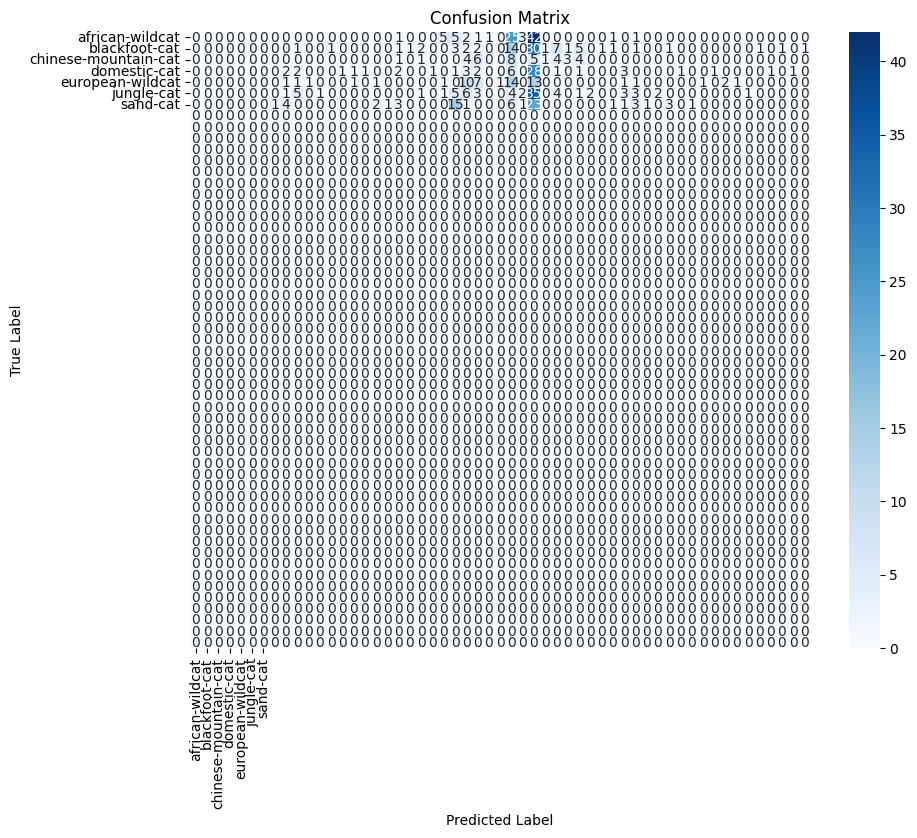

In [35]:
# Create confusion matrix
confusion_mtx = metrics.confusion_matrix(true_labels, predicted_class_indices)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [36]:
output_dir = "grayscale_images"
image_height = 224
image_width = 224

# Create directory if not exists
os.makedirs(output_dir, exist_ok=True)

# List to store processed grayscale images
grayscale_images = []

# Process images
for species in os.listdir(dataset_path):
    species_path = os.path.join(dataset_path, species)
    if os.path.isdir(species_path):
        for image_file in os.listdir(species_path):
            if image_file.endswith('.jpg'):
                image_path = os.path.join(species_path, image_file)
                image = cv2.imread(image_path)
                
                if image is not None:
                    # Convert to grayscale
                    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    resized_image = cv2.resize(grayscale_image, (image_height, image_width))
                    
                    # Convert grayscale to 3-channel image
                    grayscale_image_3c = np.repeat(np.expand_dims(resized_image, axis=-1), 3, axis=-1)
                    
                    # Preprocess for ResNet50
                    preprocessed_image = tf.keras.applications.resnet50.preprocess_input(grayscale_image_3c)
                    grayscale_images.append(preprocessed_image)

# Save the processed grayscale images
grayscale_images_np = np.array(grayscale_images)
np.save(os.path.join(output_dir, 'grayscale_images.npy'), grayscale_images_np)

In [37]:
# Load the grayscale images
grayscale_images_np = np.load(os.path.join(output_dir, 'grayscale_images.npy'))

# Get predictions
grayscale_predictions = model.predict(grayscale_images_np)

# Convert predictions to class labels
predicted_classes_grayscale = np.argmax(grayscale_predictions, axis=-1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


In [40]:
# Load images from the .npy file
images_np = np.load('train_test/images_test.npy')

true_labels = np.array([0] * len(images_np))

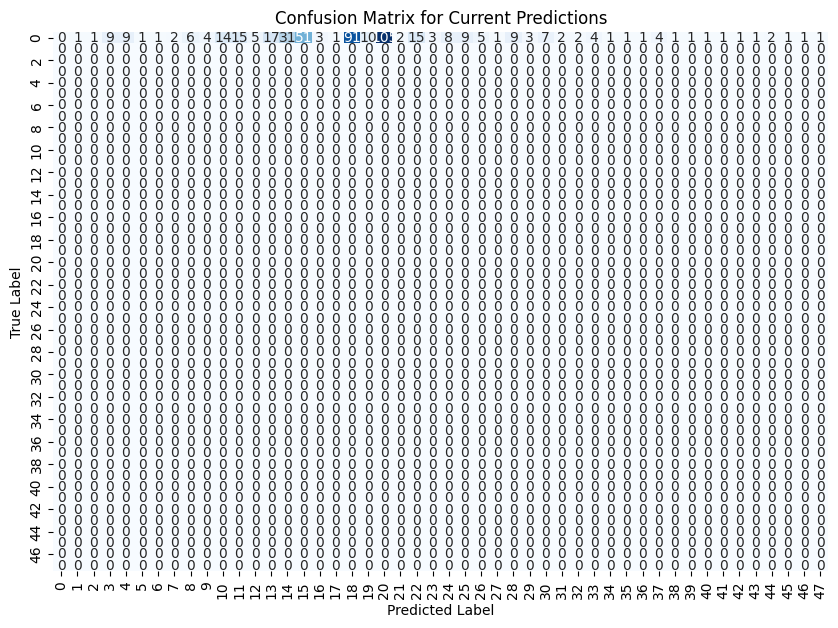

Classification Report for Current Predictions:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     465.0
          43       0.00      0.00      0.00       0.0
          49       0.00      0.00      0.00       0.0
         104       0.00      0.00      0.00       0.0
         106       0.00      0.00      0.00       0.0
         191       0.00      0.00      0.00       0.0
         214       0.00      0.00      0.00       0.0
         228       0.00      0.00      0.00       0.0
         269       0.00      0.00      0.00       0.0
         270       0.00      0.00      0.00       0.0
         272       0.00      0.00      0.00       0.0
         276       0.00      0.00      0.00       0.0
         278       0.00      0.00      0.00       0.0
         280       0.00      0.00      0.00       0.0
         281       0.00      0.00      0.00       0.0
         282       0.00      0.00      0.00       0.0
         283       0.00      0.00 

C:\Data-Science\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Data-Science\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Data-Science\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Data-Science\myenv\lib\site-packages\sklearn\metrics\_

In [44]:
# Compute confusion matrix for grayscale predictions
cm_current = confusion_matrix(true_labels, predicted_classes_grayscale)

# Compute confusion matrix for previous predictions if available
if 'previous_predictions' in locals():
    cm_previous = confusion_matrix(true_labels, previous_predictions)

# Plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(cm_current, 'Confusion Matrix for Current Predictions')

if 'cm_previous' in locals():
    plot_confusion_matrix(cm_previous, 'Confusion Matrix for Previous Predictions')

# Print classification report
print("Classification Report for Current Predictions:")
print(classification_report(true_labels, predicted_classes_grayscale))

if 'previous_predictions' in locals():
    print("Classification Report for Previous Predictions:")
    print(classification_report(true_labels, previous_predictions))


### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

In [48]:
# Load the ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add Global Average Pooling layer to get a 1D feature vector
feature_extraction_model = Sequential([
    base_model,
    GlobalAveragePooling2D()
])

# Define a dummy input to check the feature extraction model
dummy_input = np.random.rand(1, 224, 224, 3)  # Batch size 1, image size 224x224

# Run a forward pass to check output shape
dummy_features = feature_extraction_model.predict(dummy_input)
print("Feature extraction model output shape:", dummy_features.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Feature extraction model output shape: (1, 2048)


In [49]:
# Extract features
features = feature_extraction_model.predict(images_np)

# Print features shape to confirm
print("Features shape:", features.shape)

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
Features shape: (465, 2048)


In [50]:
output_dir = "deep_features"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'image_features.npy')

# Save features to .npy file
np.save(output_file, features)

# Verify by loading the saved features
loaded_features = np.load(output_file)
print("Loaded feature shape:", loaded_features.shape)

Loaded feature shape: (465, 2048)


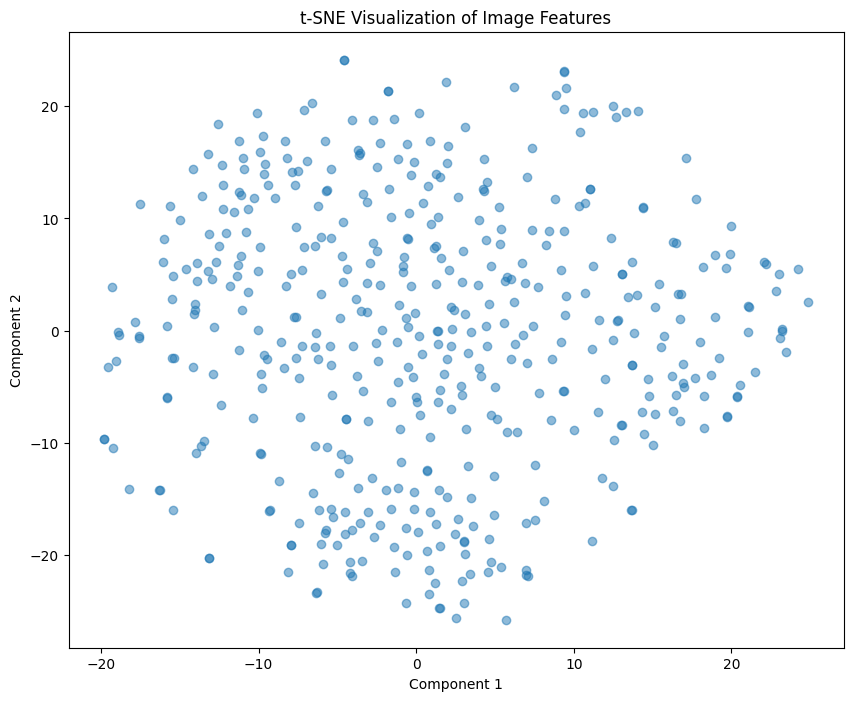

In [52]:
# Apply t-SNE to reduce features to 2D
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot the 2D features
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Image Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

In [54]:
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(features)

# Find the most similar image pairs
def find_similar_images(cosine_sim, top_n=5):
    similar_images = []
    num_images = cosine_sim.shape[0]
    for i in range(num_images):
        # Get indices of the top_n most similar images (excluding self)
        similar_indices = np.argsort(cosine_sim[i])[::-1][1:top_n+1]
        for idx in similar_indices:
            similar_images.append((i, idx, cosine_sim[i, idx]))
    return similar_images

# Find and print similar images
similar_images = find_similar_images(cosine_sim)
for img1, img2, sim in similar_images:
    print(f"Image {img1} and Image {img2} have a cosine similarity of {sim:.4f}")

Image 0 and Image 2 have a cosine similarity of 0.9386
Image 0 and Image 4 have a cosine similarity of 0.7888
Image 0 and Image 163 have a cosine similarity of 0.7821
Image 0 and Image 39 have a cosine similarity of 0.7812
Image 0 and Image 16 have a cosine similarity of 0.7802
Image 1 and Image 73 have a cosine similarity of 0.7672
Image 1 and Image 203 have a cosine similarity of 0.7365
Image 1 and Image 164 have a cosine similarity of 0.7347
Image 1 and Image 137 have a cosine similarity of 0.7294
Image 1 and Image 219 have a cosine similarity of 0.7241
Image 2 and Image 0 have a cosine similarity of 0.9386
Image 2 and Image 85 have a cosine similarity of 0.7916
Image 2 and Image 52 have a cosine similarity of 0.7913
Image 2 and Image 453 have a cosine similarity of 0.7693
Image 2 and Image 16 have a cosine similarity of 0.7647
Image 3 and Image 70 have a cosine similarity of 0.8361
Image 3 and Image 225 have a cosine similarity of 0.8278
Image 3 and Image 80 have a cosine similarit

In [57]:
from sklearn.metrics import mean_squared_error

# Compute the pairwise MSE matrix
mse_matrix = np.zeros((features.shape[0], features.shape[0]))
for i in range(features.shape[0]):
    for j in range(features.shape[0]):
        mse_matrix[i, j] = mean_squared_error(features[i], features[j])

# Find the most similar image pairs based on MSE
def find_similar_images_mse(mse_matrix, top_n=5):
    similar_images = []
    num_images = mse_matrix.shape[0]
    for i in range(num_images):
        # Get indices of the top_n most similar images (excluding self)
        similar_indices = np.argsort(mse_matrix[i])[:top_n+1]
        for idx in similar_indices:
            if idx != i:  # Avoid self-comparison
                similar_images.append((i, idx, mse_matrix[i, idx]))
    return similar_images

# Find and print similar images
similar_images_mse = find_similar_images_mse(mse_matrix)
for img1, img2, mse in similar_images_mse:
    print(f"Image {img1} and Image {img2} have an MSE of {mse:.4f}")

Image 0 and Image 2 have an MSE of 0.1085
Image 0 and Image 4 have an MSE of 0.3311
Image 0 and Image 163 have an MSE of 0.3384
Image 0 and Image 39 have an MSE of 0.3439
Image 0 and Image 85 have an MSE of 0.3587
Image 1 and Image 73 have an MSE of 0.2285
Image 1 and Image 18 have an MSE of 0.2418
Image 1 and Image 260 have an MSE of 0.2436
Image 1 and Image 45 have an MSE of 0.2501
Image 1 and Image 51 have an MSE of 0.2540
Image 2 and Image 0 have an MSE of 0.1085
Image 2 and Image 85 have an MSE of 0.3346
Image 2 and Image 52 have an MSE of 0.3418
Image 2 and Image 4 have an MSE of 0.3762
Image 2 and Image 39 have an MSE of 0.3892
Image 3 and Image 70 have an MSE of 0.2153
Image 3 and Image 225 have an MSE of 0.2254
Image 3 and Image 280 have an MSE of 0.2318
Image 3 and Image 68 have an MSE of 0.2425
Image 3 and Image 27 have an MSE of 0.2430
Image 4 and Image 39 have an MSE of 0.0082
Image 4 and Image 43 have an MSE of 0.2025
Image 4 and Image 349 have an MSE of 0.2483
Image 4 an

In [61]:
# Initialize a list to store image paths
image_paths = []

# Traverse the directories to get image paths
for species in os.listdir(dataset_path):
    species_path = os.path.join(dataset_path, species)
    if os.path.isdir(species_path):
        for image_file in os.listdir(species_path):
            if image_file.endswith('.jpg'):
                image_paths.append(os.path.join(species_path, image_file))

# Check if image paths were collected
print(f"Collected {len(image_paths)} image paths.")

# Define the function to compute Fourier features
def compute_fourier_features(image):
    # Convert image to grayscale and apply FFT
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fft_image = fft2(gray_image)
    fft_image_shifted = fftshift(fft_image)
    return np.abs(fft_image_shifted.flatten())

# Compute Fourier features for all images
fourier_features = []
for img_path in image_paths:
    image = cv2.imread(img_path)
    resized_image = cv2.resize(image, (image_height, image_width))
    features = compute_fourier_features(resized_image)
    fourier_features.append(features)

fourier_features = np.array(fourier_features)

# Save Fourier features to a .npy file
np.save('fourier_features.npy', fourier_features)

# Load Fourier features to verify
loaded_fourier_features = np.load('fourier_features.npy')
print(f"Loaded Fourier features shape: {loaded_fourier_features.shape}")

Collected 465 image paths.
Loaded Fourier features shape: (465, 50176)


Let's visualize the Fourier features of the first 3 images:

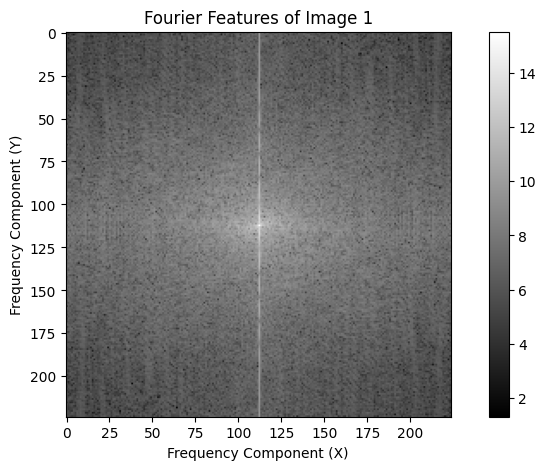

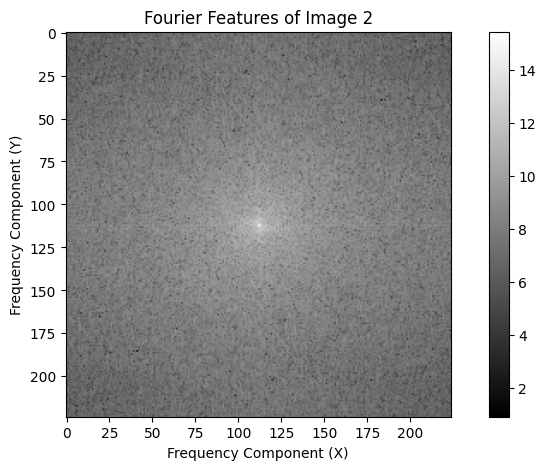

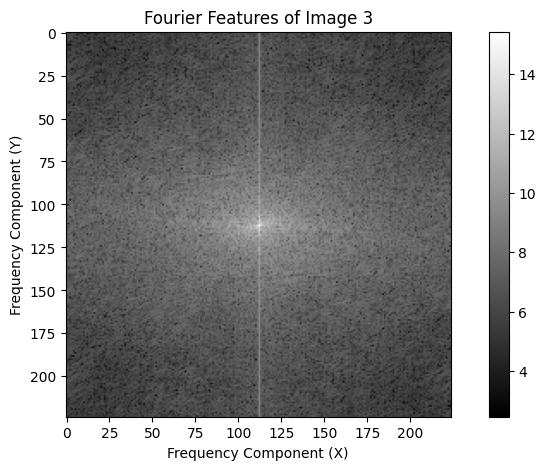

In [64]:
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.title(f'Fourier Features of Image {i+1}')
    plt.imshow(np.log1p(loaded_fourier_features[i].reshape(image_height, image_width)), cmap='gray')
    plt.colorbar()
    plt.xlabel('Frequency Component (X)')
    plt.ylabel('Frequency Component (Y)')
    plt.show()

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.